the goal is to create a notebook that would allow automatic processing of pairs of SAR images and related model data.

First part collect all variables which setting later could go to configuration file

Second part combines all steps of processing with intermidiate plotting and saving data. Later it should split to different python modules and run by a function from a separate .py with one main method, for example def rub_int_forecast_analysis which would use confic variables

I will try to organize code so rask would be in once cell so it would be convinient to make python files afterwords

At the end I can split this notebook to modules and execution part based on the hashtag at teh top of each cell (maybe automatically with chatGPT)
Would be great if variables from config files or any other varoables used in different modules would be changed to module_name.variable

In [3]:
#Import modules for exwcutions

# If using a new container, a different version of matplotlib should be installed
# To avoid the error while plotting "AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'"
# Otherwise image should be changed again 
#!pip install --user matplotlib==3.5.2

import xarray as xr

import re


#from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

In [4]:
#module

# ---------------------------------------------------------------------- #
# Name :        config.py
# Purpose :     S1 Image class definitions and functions for preparing pairs of SAR1 and SAR2
# ---------------------------------------------------------------------- #

# ---------------------------------------------------------------------- #
# USER DEFINED PARAMETERS 
#
# ---------------------------------------------------------------------- #


path_to_HH_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HH_HV_160_for batch_processing/test/HH_160'
path_to_HV_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HH_HV_160_for batch_processing/test/HV_160'
safe_folder = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/safe'


S1_prod_regex =  (r'S1[AB]{1}_EW_GRDM_1[A-Z]{3}_([0-9]{8}T[0-9]{6})_'
                 r'([0-9]{8}T[0-9]{6})_[0-9]{6}_[0-9A-Z]{6}_([0-9A-Z]{4})_Orb_Cal_TC_(H[HV]{1})_([0-9]{1,4})')
S1_safe_regex =  (r'S1[AB]{1}_EW_GRDM_1[A-Z]{3}_([0-9]{8}T[0-9]{6})_'
                 r'([0-9]{8}T[0-9]{6})_[0-9]{6}_[0-9A-Z]{6}_([0-9A-Z]{4})')

# Compile the regular expression for matching Sentinel file names.
S1_prod_regex = re.compile(S1_prod_regex)  
S1_safe_regex = re.compile(S1_safe_regex) 

# Set the grid baed on model grid
data_grid = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_surface/2023/09/07/T18Z/barents_sfc_20230907T18Zm23.nc")
# Extract X and Y coordinates, as well as longitude and latitude values from the dataset
X = data_grid['X']
Y = data_grid['Y']
lon = data_grid['lon']
lat = data_grid['lat']
# Retrieve the proj4 string defining the Lambert Conformal projection of the dataset
proj4 = data_grid.projection_lambert.proj4

In [5]:
#module

# ---------------------------------------------------------------------- #
# Name :        s1_preparation.py
# Purpose :     S1 Image class definitions and functions for preparing pairs of SAR1 and SAR2
# ---------------------------------------------------------------------- #

import re
import datetime
import os

''' 
Comments
----------

SAFE files were geocoded separatly usign snappy module usifn following parameters:

sentinel_processor(in_folder, output_folder, polarization_mode = 'DH', polarization_bands = 'HH,HV', pixel_spacing = 160, crs = custom_crs_wkt, resampling_method = 'BILINEAR_INTERPOLATION')

Regular expression for output file differs from the original safe files by having a few extra suffixes at the end, for example:
S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV_160.tif

custom_crs_wkt = 'PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],
                PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",77.5],PARAMETER["central_meridian",-25],PARAMETER["standard_parallel_1",77.5],
                PARAMETER["standard_parallel_2",77.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],
                AXIS["Northing",NORTH]]'
'''

class S1Image:
    
    ''' 
    Container for Sentinel-1 geocoded product. 
    
    Represents the essential details of a Sentinel-1 product 
    that has been processed and geocoded. The class is capable 
    of extracting attributes like timestamp, polarisation_band, 
    and resolution from the filename using a predefined regex pattern.
    
    Attributes
    ----------
    filepath : str
        - Full path to the Sentinel-1 product file.
    filename : str
        - Name of the Sentinel-1 product file.
    timestamp : datetime.datetime
        - Acquisition time of the product.
    polarisation_band : str
        - Polarisation band of the product (e.g., HH, HV).
    resolution : int
        - Resolution of the product (e.g., 160).
    '''
        
        


    @classmethod
    def find_safe_filepath(cls, filename):
        prod_match = S1_prod_regex.match(filename)
        if not prod_match:
            return None
        for safe_file in os.listdir(safe_folder):
            safe_match = S1_safe_regex.match(safe_file)
            if safe_match and all(prod_match.group(i) == safe_match.group(i) for i in range(1, 4)):
                return os.path.join(safe_folder, safe_file)
        return None
    

    def __init__(self, filepath):
        self.filepath = filepath
        self.filename = os.path.basename(filepath)
        # Attempt to match the filename against the predefined regex pattern.
        match = S1_prod_regex.search(self.filename)
        if not match:
            raise ValueError(f"File {self.filename} does not match the expected pattern.")
        self.timestamp = datetime.datetime.strptime(match.group(1), '%Y%m%dT%H%M%S')
        self.polarisation_band = match.group(3)
        self.resolution = int(match.group(4))
        self.safe_filepath = self.find_safe_filepath(self.filename)
        
    def __repr__(self):
        return f"S1Image(polarisation={self.polarisation_band}, timestamp={self.timestamp.strftime('%Y%m%dT%H%M%S')})"

    
           
        
# Function to collect and create S1Image objects for all Sentinel files in a directory.
def collect_sentinel_files(directory):
    # Initialize an empty list to store S1Image objects
    sentinel_files = []

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        # Check if the file has a .tif extension
        if filename.endswith('.tif'):
            # Create the full path to the file
            full_path = os.path.join(directory, filename)
            
            # Create a S1Image object and add it to the list
            try:
                sentinel_file = S1Image(full_path)
                sentinel_files.append(sentinel_file)
            except ValueError:
                # This will skip files that don't match the expected pattern
                continue

    # Sort the list of S1Image objects by their timestamp
    sorted_files = sorted(sentinel_files, key=lambda x: x.timestamp)
    
    return sorted_files

# Function to get pairs of Sentinel files where the difference in their timestamps is within a given limit.
def get_pairs_within_time_limit(files, hours=60):
    pairs = []
    for i in range(len(files)):
        for j in range(i+1, len(files)):
            if (files[j].timestamp - files[i].timestamp).total_seconds() <= hours * 3600:
                pairs.append((files[i], files[j]))
            else:
                break  # break inner loop since the list is sorted and no other pairs will fit the criteria
    return pairs

In [6]:
import re
import datetime
import os

class S1Image:

    @classmethod
    def find_safe_filepath(cls, filename):
        prod_match = S1_prod_regex.match(filename)
        if not prod_match:
            return None
        for safe_file in os.listdir(safe_folder):
            safe_match = S1_safe_regex.match(safe_file)
            if safe_match and all(prod_match.group(i) == safe_match.group(i) for i in range(1, 4)):
                return os.path.join(safe_folder, safe_file)
        return None

    def __init__(self, filepath):
        self.filepath = filepath
        self.filename = os.path.basename(filepath)
        match = S1_prod_regex.search(self.filename)
        if not match:
            raise ValueError(f"File {self.filename} does not match the expected pattern.")
        self.timestamp = datetime.datetime.strptime(match.group(1), '%Y%m%dT%H%M%S')
        self.polarisation_band = match.group(4)
        self.resolution = int(match.group(5))
        self.safe_filepath = self.find_safe_filepath(self.filename)
        
    def __repr__(self):
        return f"S1Image(polarisation={self.polarisation_band}, timestamp={self.timestamp.strftime('%Y%m%dT%H%M%S')})"

         
        
# Function to collect and create S1Image objects for all Sentinel files in a directory.
def collect_sentinel_files(directory):
    # Initialize an empty list to store S1Image objects
    sentinel_files = []

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        # Check if the file has a .tif extension
        if filename.endswith('.tif'):
            # Create the full path to the file
            full_path = os.path.join(directory, filename)
            
            # Create a S1Image object and add it to the list
            try:
                sentinel_file = S1Image(full_path)
                sentinel_files.append(sentinel_file)
            except ValueError:
                # This will skip files that don't match the expected pattern
                continue

    # Sort the list of S1Image objects by their timestamp
    sorted_files = sorted(sentinel_files, key=lambda x: x.timestamp)
    
    return sorted_files

# Function to get pairs of Sentinel files where the difference in their timestamps is within a given limit.
def get_pairs_within_time_limit(files, hours=60):
    pairs = []
    for i in range(len(files)):
        for j in range(i+1, len(files)):
            if (files[j].timestamp - files[i].timestamp).total_seconds() <= hours * 3600:
                pairs.append((files[i], files[j]))
            else:
                break  # break inner loop since the list is sorted and no other pairs will fit the criteria
    return pairs


In [7]:
# Execution

# Collect SentinelFile objects for files in the HH and HV directories.
HH_files = collect_sentinel_files(path_to_HH_files)
HV_files = collect_sentinel_files(path_to_HV_files)

# Get pairs of SentinelFile objects where their timestamps are within 60 hours of each other.
HH_pairs = get_pairs_within_time_limit(HH_files)
HV_pairs = get_pairs_within_time_limit(HV_files)

# Print details for each pair.
for index, pair in enumerate(HV_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}; resolution: {pair[0].resolution}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}; resolution: {pair[1].resolution}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV_160.tif 
timestamp: 2022-11-20 08:01:55; resolution: 160
SAR2: S1A_EW_GRDM_1SDH_20221122T074535_20221122T074639_046004_05816B_9FC9_Orb_Cal_TC_HV_160.tif 
timestamp: 2022-11-22 07:45:35; resolution: 160
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif 
timestamp: 2023-02-12 08:01:51; resolution: 160
SAR2: S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014_Orb_Cal_TC_HV_160.tif 
timestamp: 2023-02-14 07:45:31; resolution: 160


In [8]:
print(pair[0].filename)

S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif


In [9]:
 print(pair[0].safe_filepath)

/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/safe/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB.SAFE


In [248]:
#module

# ---------------------------------------------------------------------- #
# Name :        SAR1_SAR2_drift_retrivial.py
# Purpose :     Retrieve reference drift for  further comparison with the model data and reference forecast.  
# ---------------------------------------------------------------------- #
'''
purpose:
1. for HV open pair one
2. Calculate feature tracking, pattren matching and safe as images:
 - r, hpm, ssmi
 - drift 
3. Repeat the same for pair in HH_files
4. Compare hpm for hh and hv and create combined r, h, ssmi, u, v
 - as output safe a plot showing when hh > hv and an img
 5. Expor u and v forcsv for forecastin
'''

'\npurpose:\n1. for HV open pair one\n2. Calculate feature tracking, pattren matching and safe as images:\n - r, hpm, ssmi\n - drift \n3. Repeat the same for pair in HH_files\n4. Compare hpm for hh and hv and create combined r, h, ssmi, u, v\n - as output safe a plot showing when hh > hv and an img\n 5. Expor u and v forcsv for forecastin\n'

In [131]:
print(HV_pairs[0][0], HV_pairs[0][1].filepath)
print(HV_pairs[1][0], HV_pairs[1][1])

S1Image(polarisation=HV, timestamp=20221120T080155) /home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HH_HV_160_for batch_processing/test/HV_160/S1A_EW_GRDM_1SDH_20221122T074535_20221122T074639_046004_05816B_9FC9_Orb_Cal_TC_HV_160.tif
S1Image(polarisation=HV, timestamp=20230212T080151) S1Image(polarisation=HV, timestamp=20230214T074531)


In [259]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from osgeo import gdal
from osgeo import osr
from nansat import Nansat, Domain, NSR
from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

#import sys
#sys.path.append(r'./nersc_drift_algorithm/sea_ice_drift')
#from pmlib_with_ssim import pattern_matching

%matplotlib inline

In [227]:
# HV processing
# Download arrays
f1 = gdal.Open(HV_pairs[1][0].filepath)
f2 = gdal.Open(HV_pairs[1][1].filepath)

#Set domains based on the data
n1_domen = Nansat(HV_pairs[1][0].filepath)
n2_domen = Nansat(HV_pairs[1][1].filepath)

In [228]:
#Load the data from the files into numpy arrays for further processing.
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()

#Pre-process images to ensure consistent visualization and handle blank spots issue after pattern patching.
a1 = get_uint8_image(a1, None, None, 1, 99)
a2 = get_uint8_image(a2, None, None, 1, 99)

VMIN:  0.0
VMAX:  0.021238385755568752
VMIN:  0.0
VMAX:  0.01598892150446774


In [229]:
# Create three Nansat objects with original tiff domains imported from gdal object.
n1 = Nansat.from_domain(n1_domen, a1)
n2 = Nansat.from_domain(n2_domen, a2)

In [230]:
# Close the dataset
f2 = None
f3 = None

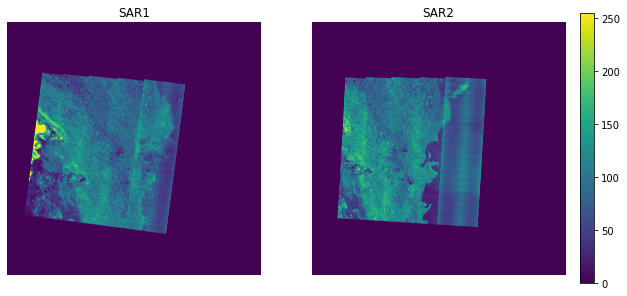

In [235]:
#Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
im1 = ax[0].imshow(n1[1], clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(n2[1], clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im2, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR1")
ax[1].set_title("SAR2")

#ax[0].set_xlim([0.28e6, 0.62e6]) 
#ax[0].set_ylim([0.16e6, 0.6e6])

#ax[1].set_xlim([0.28e6, 0.62e6]) 
#ax[1].set_ylim([0.16e6, 0.6e6])
plt.show()




In [242]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 49994
Domain filter: 50000 -> 50000
Keypoints matched 5.30035924911499
Ratio test 0.600000 found 952 keypoints
MaxDrift filter: 952 -> 949
LSTSQ filter: 949 -> 949


In [243]:
# get lon/lat coordinates of the border of images
# when using .tiff instead of .safe bounds include nodata area around that makes the extent bigger than needed
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()

In [244]:
# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

#Get bound in rows and columns correspoding to the image borders
r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
               
min_row, max_row, min_col, max_col = min(r), max(r), min(c), max(c)

In [245]:
# Extract the subset grid out of the model grid based on the image bounds
#That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
X_subset = X[min_col:max_col+1]
Y_subset = Y[min_row:max_row+1]
lon_subset = lon[min_row:max_row+1, min_col:max_col+1]
lat_subset = lat[min_row:max_row+1, min_col:max_col+1]


# Prepare coordinates for patern matching input
lon1pm = lon_subset.data
lat1pm = lat_subset.data

# Set up coordinates in meters for visualizing the pattern matching results.
x1pm, y1pm = np.meshgrid(X_subset, Y_subset)

In [246]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm,best_ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=100,
                                                           max_border=100,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/opt/conda/lib/python

/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


100% 03867.8 00041.3 03325.0 00146.0 -12.0 1.00 0nan1% 04148.8 04009.3 03599.0 04055.0 -12.0 1.00 0nan01% 02789.8 04478.3 02286.0 04400.0 -12.0 1.00 0nan15% 04007.8 03838.3 03463.0 03875.0 -12.0 1.00 0nan19% 01414.8 03619.3 01139.0 03630.0 +03.0 0.68 3.63
 Pattern matching - OK! (141 sec)


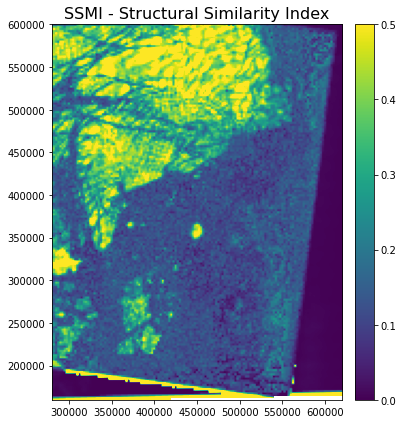

In [258]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.5, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


In [260]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=100,
                                                           max_border=100,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


100% 03867.8 00041.3 03325.0 00146.0 -12.0 1.00 0nan34% 01148.8 02947.3 00762.0 02738.0 -12.0 0.25 3.0429% 04039.8 03181.3 03493.0 03235.0 -12.0 1.00 0nan
 Pattern matching - OK! (133 sec)


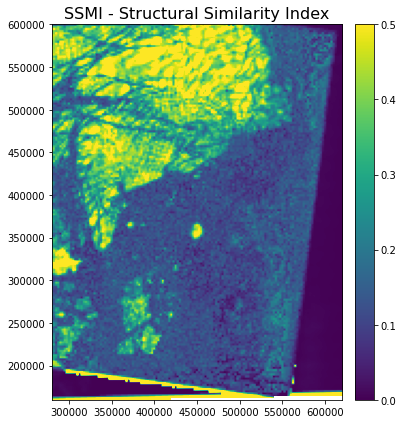

In [261]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.5, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


In [203]:
# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

model_d = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')

n1.reproject(model_d) 
n1b1 = n1[1]
n1.undo()

n2.reproject(model_d) 
n2b1 = n2[1]
n2.undo()

In [147]:
formatted_timestamp = HH_pairs[2][0].timestamp.strftime('%Y-%m-%dT%H:%M:%S')
print(formatted_timestamp)
%store  formatted_timestamp

IndexError: list index out of range